### 📡 딥러닝 CNN 프로젝트 02 - 위성 사진 분류 프로젝트
- 서로 다른 4가지 지형을 촬영한 위성 사진 (저용량)

#### 🖼️ 예시

- 왼쪽에서부터 cloudy(구름), desert(사막 지대), green_area(숲 지대), water(물 지대)

<div style='display: flex; margin-left: 10px;'>
    <div>
        <img src='../datasets/satellite/original/cloudy/train_10021.jpg' width='200px'>
    </div>
    <div>
        <img src='../datasets/satellite/original/desert/desert(1).jpg' width='200px' style='margin-left: 15px;'>
    </div>
    <div>
        <img src='../datasets/satellite/original/green_area/Forest_1404.jpg' width='200px' style='margin-left: 15px;'>
    </div>
    <div>
        <img src='../datasets/satellite/original/water/SeaLake_1.jpg' width='200px' style='margin-left: 15px;'>
    </div>
</div>

### 💻 데이터 전처리
- original로부터 train, validation, test 분리
- 실제 디렉토리를 생성하는 게 아닌, original로 DataFrame을 만든 뒤 각각의 DataFrame으로 분리

In [5]:
# 이미지와 배치 사이즈 설정
IMAGE_SIZE = 64
BATCH_SIZE = 20

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = '../datasets/satellite/original/'

# ImageDataGenerator 선언 - RGB 값을 0 ~ 1사이로 스케일링만
image_data_generator = ImageDataGenerator(rescale=1./255)

generator = image_data_generator.flow_from_directory(root,
                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='categorical')

print(generator.class_indices)

Found 5631 images belonging to 4 classes.
{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


In [7]:
# class_indices의 key: value 순서를 반대로 한 새로운 dict 생성
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'cloudy', 1: 'desert', 2: 'green_area', 3: 'water'}

In [8]:
target_names = []

# 반복문으로 위 dict의 문자열(value)을 target_names에 추가
for target in generator.classes:
    target_names.append(target_name[target])

In [9]:
import pandas as pd

# 경로, target_names(list) 및 target 클래스로 데이터프레임 생성
original_df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names ,'targets': generator.classes})

# file_path의 '\\'를 '/'로 대체
original_df.loc[:, 'file_paths'] = original_df.file_paths.apply(lambda x: x.replace('\\', '/'))

original_df

,file_paths,target_names,targets
0,../datasets/satellite/original/cloudy/train_10...,cloudy,0
1,../datasets/satellite/original/cloudy/train_10...,cloudy,0
2,../datasets/satellite/original/cloudy/train_10...,cloudy,0
3,../datasets/satellite/original/cloudy/train_10...,cloudy,0
4,../datasets/satellite/original/cloudy/train_10...,cloudy,0
...,...,...,...
5626,../datasets/satellite/original/water/SeaLake_9...,water,3
5627,../datasets/satellite/original/water/SeaLake_9...,water,3
5628,../datasets/satellite/original/water/SeaLake_9...,water,3
5629,../datasets/satellite/original/water/SeaLake_9...,water,3


#### 데이터 세트 분리

In [10]:
from sklearn.model_selection import train_test_split

# train, test 데이터 세트 분할
train_images, test_images, train_targets, test_targets = \
            train_test_split(original_df.file_paths,
                             original_df.targets,
                             stratify=original_df.targets,
                             test_size=0.2,
                             random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
3    1200
0    1200
2    1200
1     904
Name: count, dtype: int64
targets
2    300
0    300
3    300
1    227
Name: count, dtype: int64


In [11]:
# train, validation 데이터 세트 분할
train_images, validation_images, train_targets, validation_targets = \
            train_test_split(train_images,
                             train_targets,
                             stratify=train_targets,
                             test_size=0.2,
                             random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())

targets
0    960
3    960
2    960
1    723
Name: count, dtype: int64
targets
0    240
2    240
3    240
1    181
Name: count, dtype: int64


In [12]:
# train, validation, test Dataframe 생성
train_df = original_df.iloc[train_images.index].reset_index(drop=True)
validation_df = original_df.iloc[validation_images.index].reset_index(drop=True)
test_df = original_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(3603, 3)
(901, 3)
(1127, 3)


### 💻 모델 선정
- 이하의 사전 훈련 모델 중 프로젝트에 사용할 모델 선정
> - VGG16
> - Resnet50V2
> - Xception
> - MobileNetV2
- 상대적으로 유사도가 높은 모델들을 프로젝트에 사용

#### VGG16

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image 1:
('n09288635', 'geyser', 0.54915637)
geyser 54.9156%


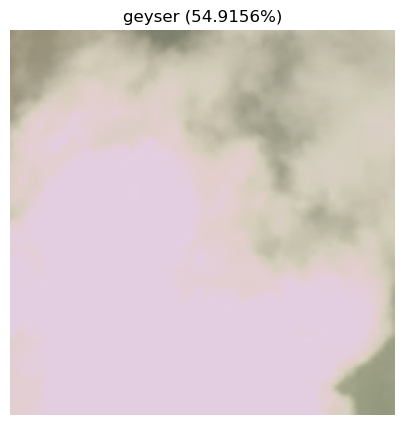



Image 2:
('n04376876', 'syringe', 0.024055123)
syringe 2.4055%


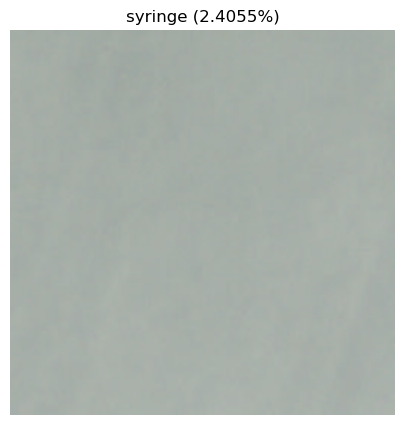



Image 3:
('n09193705', 'alp', 0.09580605)
alp 9.5806%


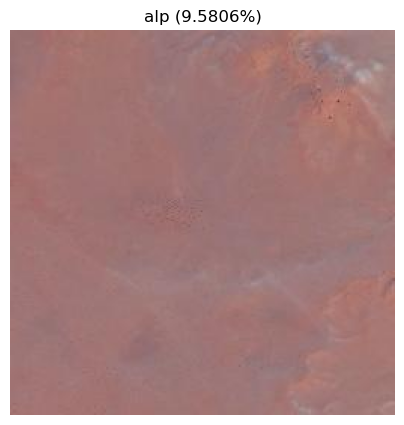



Image 4:
('n02264363', 'lacewing', 0.13153918)
lacewing 13.1539%


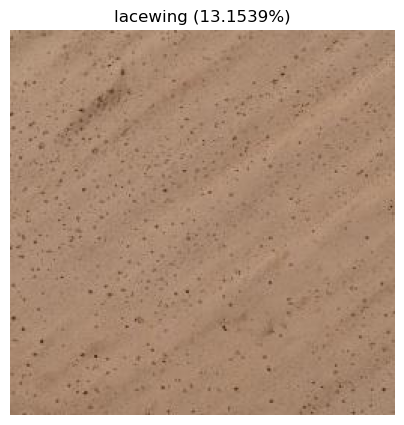



Image 5:
('n03291819', 'envelope', 0.039569654)
envelope 3.957%


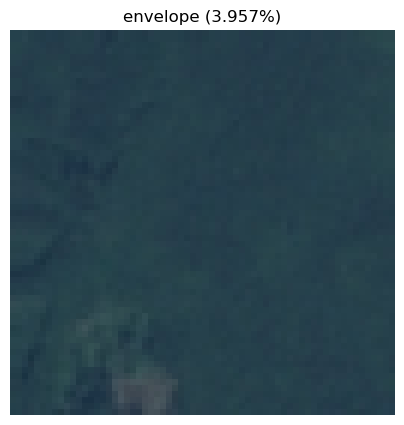



Image 6:
('n03291819', 'envelope', 0.028502993)
envelope 2.8503%


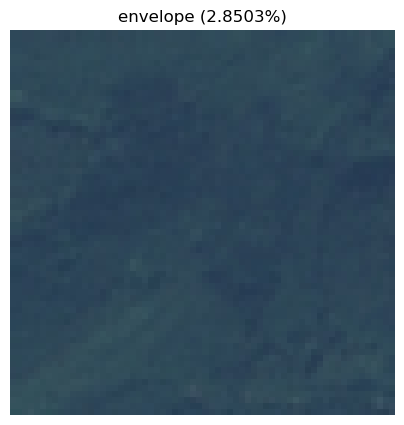



Image 7:
('n04548280', 'wall_clock', 0.023702923)
wall_clock 2.3703%


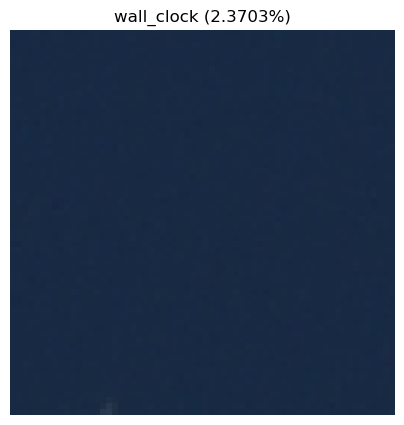



Image 8:
('n04548280', 'wall_clock', 0.03332473)
wall_clock 3.3325%


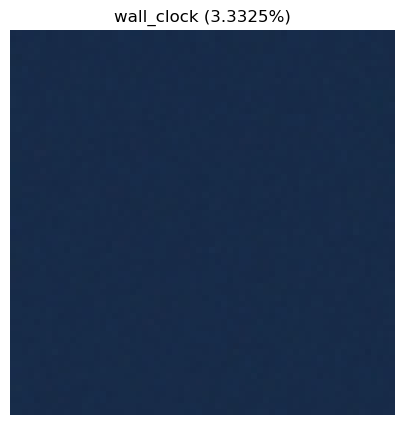

In [10]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions
import cv2
import matplotlib.pyplot as plt
import os

# VGG16 모델
model = VGG16(weights='imagenet')

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    image = load_img(img_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

# 이미지 출력 함수 선언
def show_image_with_prediction(image, prediction):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    title = f'{prediction[1]} ({np.round(float(prediction[2]) * 100, 4)}%)'
    plt.title(title)
    plt.show()

# 이미지 파일 경로 리스트
image_paths = [
    '../datasets/satellite/original/cloudy/train_10021.jpg',
    '../datasets/satellite/original/cloudy/train_10043.jpg',
    '../datasets/satellite/original/desert/desert(1).jpg',
    '../datasets/satellite/original/desert/desert(10).jpg',
    '../datasets/satellite/original/green_area/Forest_1404.jpg',
    '../datasets/satellite/original/green_area/Forest_1419.jpg',
    '../datasets/satellite/original/water/SeaLake_1.jpg',
    '../datasets/satellite/original/water/SeaLake_1004.jpg'
]

# 이미지를 로드하고 배열로 변환
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# 이미지 예측
predictions = model.predict(images)

# 예측 결과를 디코딩하고 출력
for i, img_path in enumerate(image_paths):
    # 원본 이미지를 로드하고 색상 변환
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    prediction = decode_predictions(np.expand_dims(predictions[i], axis=0))

    # 예측 결과 출력 및 이미지 표시
    print(f"Image {i + 1}:")
    print(prediction[0][0])
    print(prediction[0][0][1], f'{np.round(prediction[0][0][2] * 100, 4)}%')
    
    show_image_with_prediction(image, prediction[0][0])
    print("\n")

#### Resnet50V2

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image 1:
('n06359193', 'web_site', 0.014165502)
web_site 1.4166%


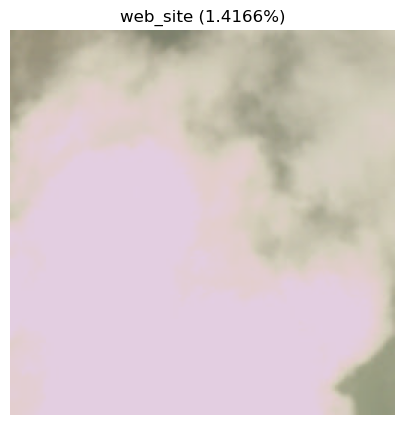



Image 2:
('n04019541', 'puck', 0.06834364)
puck 6.8344%


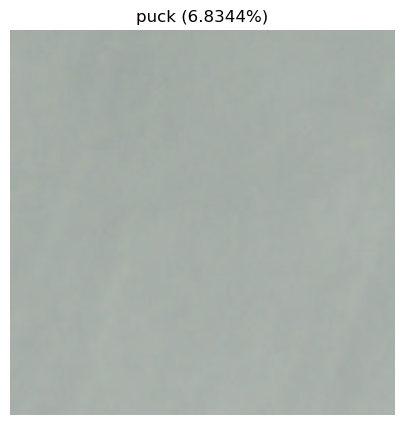



Image 3:
('n03291819', 'envelope', 0.21530887)
envelope 21.5309%


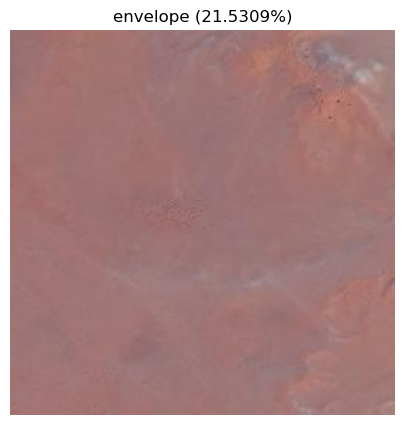



Image 4:
('n02834397', 'bib', 0.09209607)
bib 9.2096%


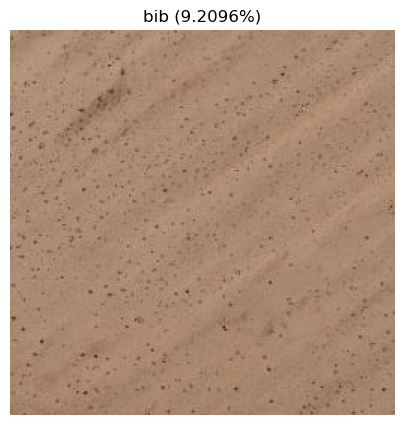



Image 5:
('n03291819', 'envelope', 0.8581783)
envelope 85.8178%


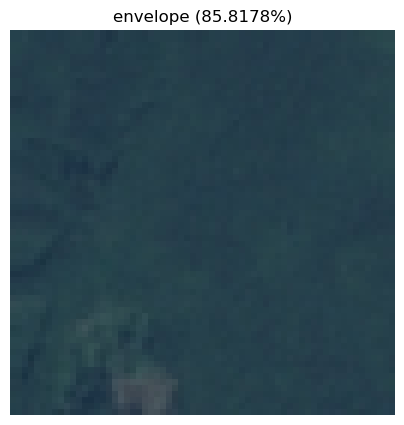



Image 6:
('n03291819', 'envelope', 0.8083002)
envelope 80.83%


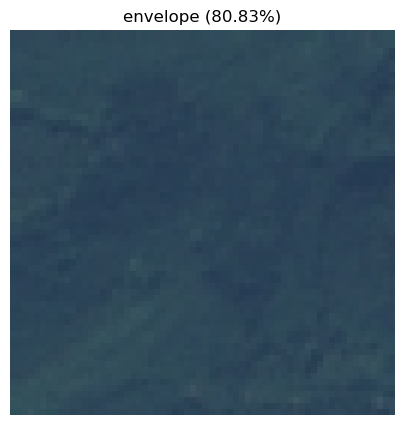



Image 7:
('n02840245', 'binder', 0.12418983)
binder 12.419%


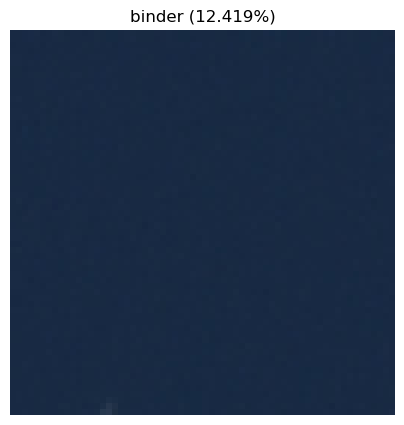



Image 8:
('n02840245', 'binder', 0.22623707)
binder 22.6237%


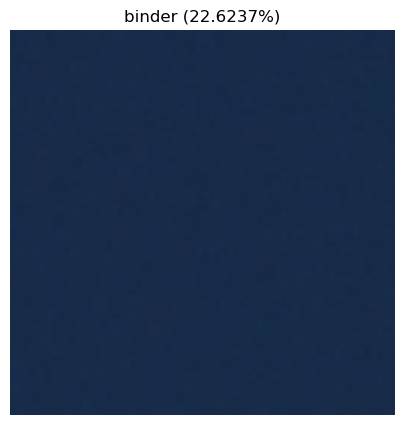

In [12]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import ResNet50, decode_predictions
import cv2
import matplotlib.pyplot as plt
import os

# Resnet50 모델
model = ResNet50(weights='imagenet')

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    image = load_img(img_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

# 이미지 출력 함수 선언
def show_image_with_prediction(image, prediction):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    title = f'{prediction[1]} ({np.round(float(prediction[2]) * 100, 4)}%)'
    plt.title(title)
    plt.show()

# 이미지 파일 경로 리스트
image_paths = [
    '../datasets/satellite/original/cloudy/train_10021.jpg',
    '../datasets/satellite/original/cloudy/train_10043.jpg',
    '../datasets/satellite/original/desert/desert(1).jpg',
    '../datasets/satellite/original/desert/desert(10).jpg',
    '../datasets/satellite/original/green_area/Forest_1404.jpg',
    '../datasets/satellite/original/green_area/Forest_1419.jpg',
    '../datasets/satellite/original/water/SeaLake_1.jpg',
    '../datasets/satellite/original/water/SeaLake_1004.jpg'
]

# 이미지를 로드하고 배열로 변환
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# 이미지 예측
predictions = model.predict(images)

# 예측 결과를 디코딩하고 출력
for i, img_path in enumerate(image_paths):
    # 원본 이미지를 로드하고 색상 변환
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    prediction = decode_predictions(np.expand_dims(predictions[i], axis=0))

    # 예측 결과 출력 및 이미지 표시
    print(f"Image {i + 1}:")
    print(prediction[0][0])
    print(prediction[0][0][1], f'{np.round(prediction[0][0][2] * 100, 4)}%')
    
    show_image_with_prediction(image, prediction[0][0])
    print("\n")

#### Xception

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image 1:
('n04127249', 'safety_pin', 1.0)
safety_pin 100.0%


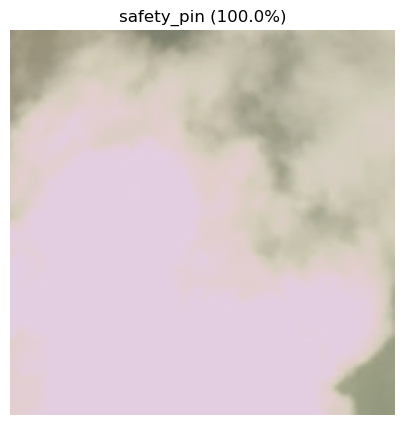



Image 2:
('n04127249', 'safety_pin', 1.0)
safety_pin 100.0%


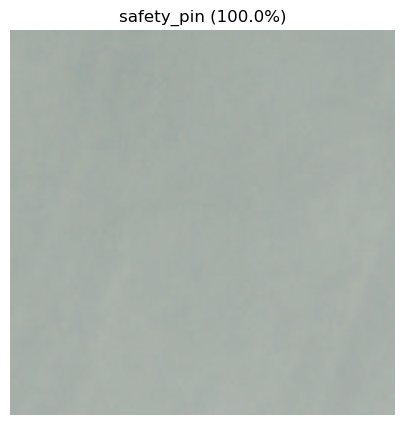



Image 3:
('n04127249', 'safety_pin', 1.0)
safety_pin 100.0%


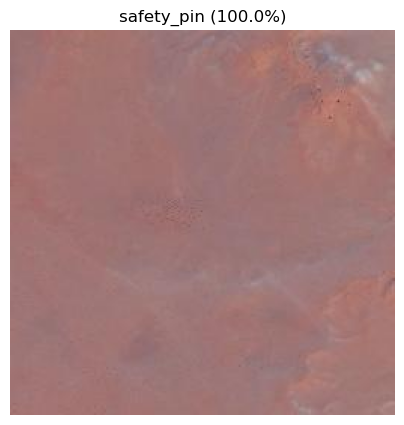



Image 4:
('n03775546', 'mixing_bowl', 0.99844944)
mixing_bowl 99.8449%


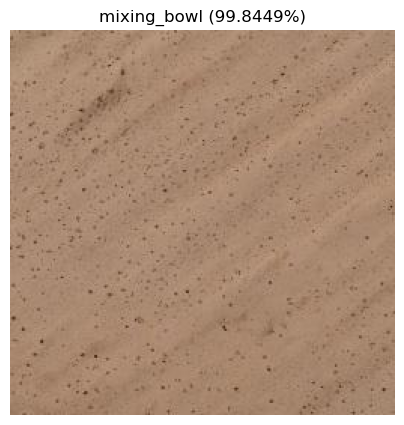



Image 5:
('n03775546', 'mixing_bowl', 1.0)
mixing_bowl 100.0%


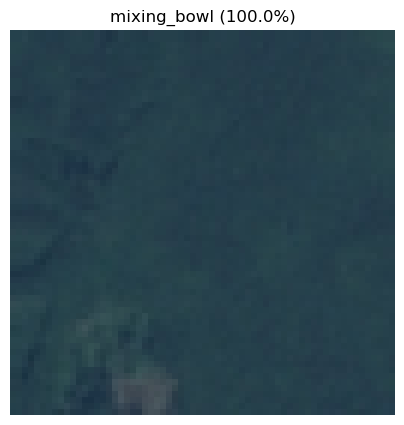



Image 6:
('n03775546', 'mixing_bowl', 1.0)
mixing_bowl 100.0%


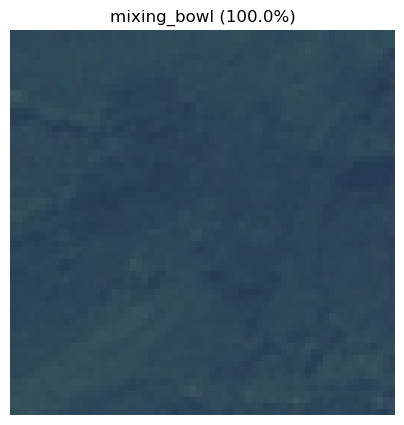



Image 7:
('n03775546', 'mixing_bowl', 1.0)
mixing_bowl 100.0%


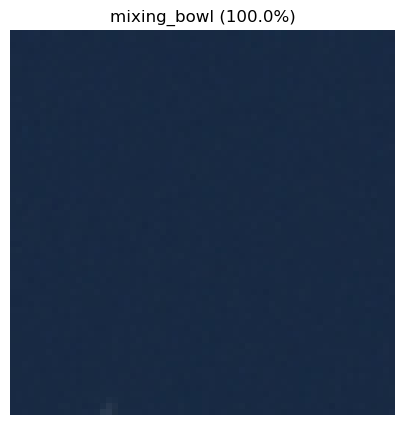



Image 8:
('n03775546', 'mixing_bowl', 1.0)
mixing_bowl 100.0%


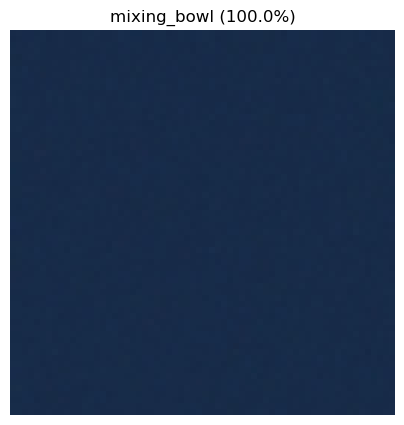

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import Xception, decode_predictions
import cv2
import matplotlib.pyplot as plt
import os

# Xception 모델
model = Xception(weights='imagenet')

# 이미지 로드 및 전처리 함수
# Xception 모델은 사이즈 다르게
def load_and_preprocess_image(img_path, target_size=(299, 299)):
    image = load_img(img_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

# 이미지 출력 함수 선언
def show_image_with_prediction(image, prediction):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    title = f'{prediction[1]} ({np.round(float(prediction[2]) * 100, 4)}%)'
    plt.title(title)
    plt.show()

# 이미지 파일 경로 리스트
image_paths = [
    '../datasets/satellite/original/cloudy/train_10021.jpg',
    '../datasets/satellite/original/cloudy/train_10043.jpg',
    '../datasets/satellite/original/desert/desert(1).jpg',
    '../datasets/satellite/original/desert/desert(10).jpg',
    '../datasets/satellite/original/green_area/Forest_1404.jpg',
    '../datasets/satellite/original/green_area/Forest_1419.jpg',
    '../datasets/satellite/original/water/SeaLake_1.jpg',
    '../datasets/satellite/original/water/SeaLake_1004.jpg'
]

# 이미지를 로드하고 배열로 변환
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# 이미지 예측
predictions = model.predict(images)

# 예측 결과를 디코딩하고 출력
for i, img_path in enumerate(image_paths):
    # 원본 이미지를 로드하고 색상 변환
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    prediction = decode_predictions(np.expand_dims(predictions[i], axis=0))

    # 예측 결과 출력 및 이미지 표시
    print(f"Image {i + 1}:")
    print(prediction[0][0])
    print(prediction[0][0][1], f'{np.round(prediction[0][0][2] * 100, 4)}%')
    
    show_image_with_prediction(image, prediction[0][0])
    print("\n")

#### MobileNetV2

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image 1:
('n06359193', 'web_site', 0.014165502)
web_site 1.4166%


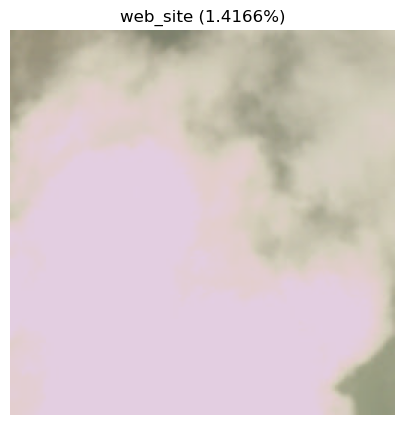



Image 2:
('n04019541', 'puck', 0.06834364)
puck 6.8344%


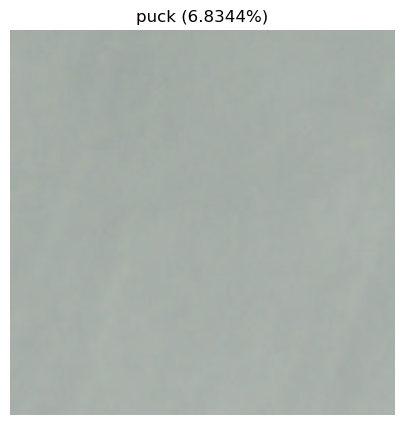



Image 3:
('n03291819', 'envelope', 0.21530887)
envelope 21.5309%


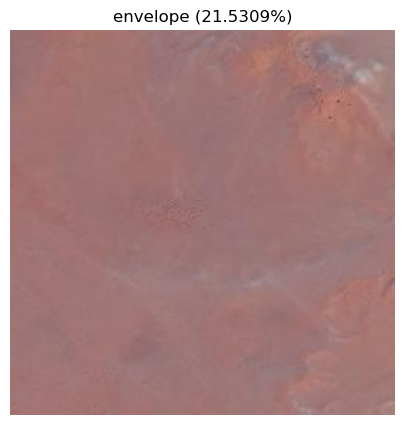



Image 4:
('n02834397', 'bib', 0.09209607)
bib 9.2096%


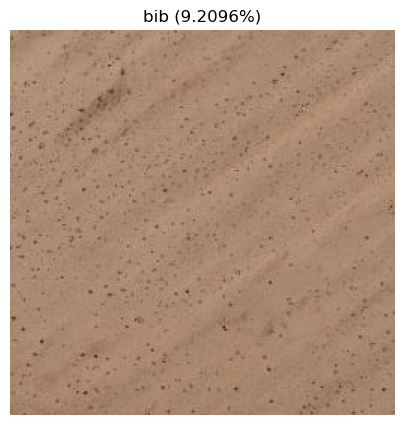



Image 5:
('n03291819', 'envelope', 0.8581783)
envelope 85.8178%


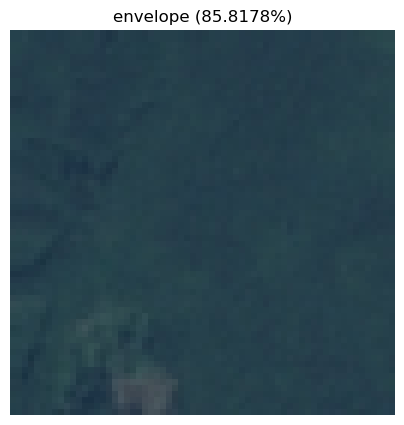



Image 6:
('n03291819', 'envelope', 0.8083002)
envelope 80.83%


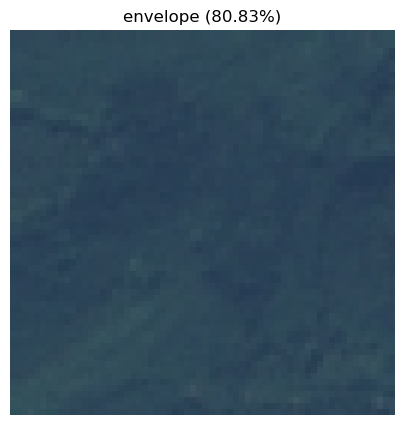



Image 7:
('n02840245', 'binder', 0.12418983)
binder 12.419%


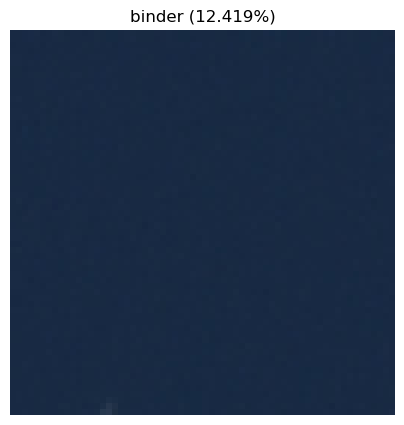



Image 8:
('n02840245', 'binder', 0.22623707)
binder 22.6237%


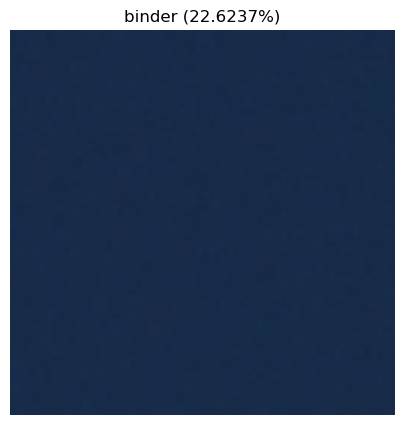

In [12]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import ResNet50, decode_predictions
import cv2
import matplotlib.pyplot as plt
import os

# Resnet50 모델
model = ResNet50(weights='imagenet')

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    image = load_img(img_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

# 이미지 출력 함수 선언
def show_image_with_prediction(image, prediction):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    title = f'{prediction[1]} ({np.round(float(prediction[2]) * 100, 4)}%)'
    plt.title(title)
    plt.show()

# 이미지 파일 경로 리스트
image_paths = [
    '../datasets/satellite/original/cloudy/train_10021.jpg',
    '../datasets/satellite/original/cloudy/train_10043.jpg',
    '../datasets/satellite/original/desert/desert(1).jpg',
    '../datasets/satellite/original/desert/desert(10).jpg',
    '../datasets/satellite/original/green_area/Forest_1404.jpg',
    '../datasets/satellite/original/green_area/Forest_1419.jpg',
    '../datasets/satellite/original/water/SeaLake_1.jpg',
    '../datasets/satellite/original/water/SeaLake_1004.jpg'
]

# 이미지를 로드하고 배열로 변환
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# 이미지 예측
predictions = model.predict(images)

# 예측 결과를 디코딩하고 출력
for i, img_path in enumerate(image_paths):
    # 원본 이미지를 로드하고 색상 변환
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    prediction = decode_predictions(np.expand_dims(predictions[i], axis=0))

    # 예측 결과 출력 및 이미지 표시
    print(f"Image {i + 1}:")
    print(prediction[0][0])
    print(prediction[0][0][1], f'{np.round(prediction[0][0][2] * 100, 4)}%')
    
    show_image_with_prediction(image, prediction[0][0])
    print("\n")

#### 중간 분석
- 위 모델들과 현재 이미지 데이터 세트와는 유사도가 낮은 것으로 추정

### 모델 선정 결과
- 각 사전 훈련 모델이 훈련한 데이터 세트와 이번에 사용하는 데이터 세트의 유사도가 낮기 때문에  
  유사도로 사용할 모델을 선정하는 것은 무의미함
- 결국 다른 기준을 마련해야 하는데, 학습에 소요되는 시간을 고려해봤을 때  
  모델의 구조가 가장 단순한 VGG16을 선정하는 것이 최선인 것으로 판단

### 🚩 1st Cycle - VGG16

#### 스케일링 방식 확인 (Tensorflow / Torch)

In [35]:
# 이미지의 RGB 값 분포를 히스토그램으로 시각화하는 함수
def show_pixel_histogram(image):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    titles = ['Red', 'Green', 'Blue']
    for i in range(3):
        axs[i].hist(image[:, :, i].flatten(), bins=100, alpha=0.5)
        title_str = titles[i]
        axs[i].set(title=title_str)

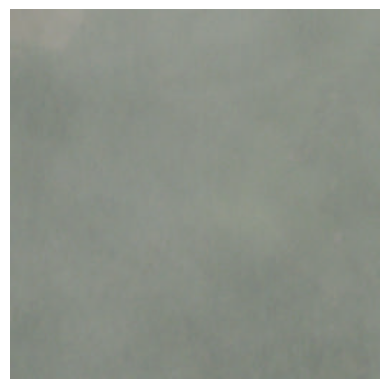

In [34]:
import cv2
import matplotlib.pyplot as plt

# 무작위로 고른 이미지 출력
image = cv2.cvtColor(cv2.imread(train_df.file_paths.iloc[365]), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

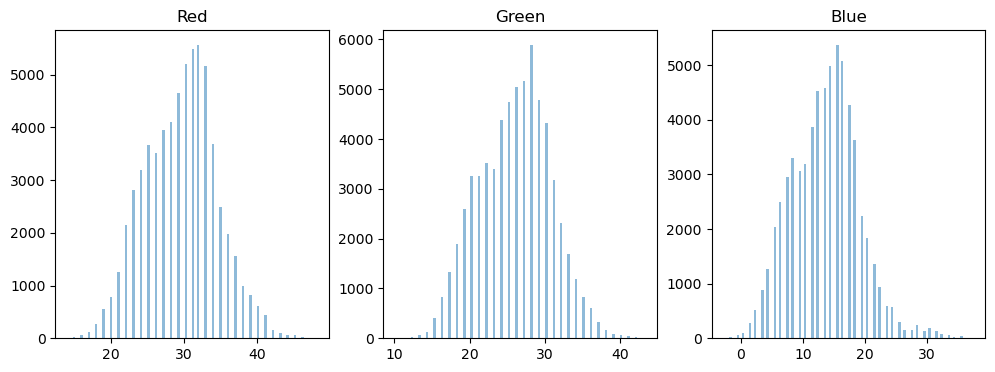

In [18]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input

# RGB를 전처리한 결과를 히스토그램으로 시각화
scaled_image_vgg = vgg_preprocess_input(image)
show_pixel_histogram(scaled_image_vgg)

#### 중간 분석
- VGG16은 TensorFlow 방식으로 스케일링 함

#### flow 생성
> - 위의 DataFrame으로부터 flow

In [103]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

IMAGE_SIZE = 64
BATCH_SIZE = 20

# train 데이터의 전처리 함수 - Augmentation + 스케일링
def preprocessing_scaling_for_train(image, mode='tf'):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0, scale_limit=(0.5, 1.5), rotate_limit=90, border_mode=cv2.BORDER_CONSTANT, p=0.5),
        A.RandomResizedCrop(width=244, height=244, scale=(0.1, 0.5), p=1)
    ], p=0.8)
    
    image = aug(image=image)['image']
    
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

# validation, test 데이터의 전처리 함수 - 스케일링
def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf':
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch':
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

# VGG16 모델을 사용하기 때문에, 해당 모델의 스케일링 방식인 tf 사용
train_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling_for_train)
validation_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)
test_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)

# 각 dataframe으로부터 flow한 train, validation, test flow 생성 - 모델 fit 및 evalutaion 용도
train_flow = train_generator.flow_from_dataframe(dataframe=train_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_flow = validation_generator.flow_from_dataframe(dataframe=validation_df, 
                                                           x_col='file_paths', 
                                                           y_col='target_names',
                                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                           class_mode='categorical')

test_flow = test_generator.flow_from_dataframe(dataframe=test_df, 
                                               x_col='file_paths', 
                                               y_col='target_names',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='categorical')

# 각 flow의 클래스 종류 출력 (제대로 생성되었는지 확인)
print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 3603 validated image filenames belonging to 4 classes.
Found 901 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.
{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}
{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}
{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


#### 모델 생성 및 학습

In [77]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1, l2

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

IMAGE_SIZE = 64
BATCH_SIZE = 20

# 모델 생성 함수
def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # 입력받은 model_name에 따라 다른 모델 사용
    # VGG16
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')

    # ResNet50V2
    elif model_name == 'resnet50':
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    # Xception (Inception 기반)
    elif model_name == 'xception':
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')

    # Mobilenet
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    # 모델의 출력값을 변수 x에 할당
    x = model.output

    # Classifier
    # VGG16 이외의 모델은 층 구조가 깊기 때문에 Dropout 사용 
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
        
    x = Dense(100, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)

    # 이미지 데이터의 클래스가 4가지였기 때문에 Dense도 7로 지정
    output = Dense(4, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)

    # 함수의 verbose 파라미터를 True로 설정 시, 모델 객체 생성과 함께 구조도 같이 출력
    if verbose:
        model.summary()

    # 모델 객체 반환
    return model

In [78]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# VGG16 모델 생성 (+ 모델 구조 출력)
model = create_model(model_name='vgg16', verbose=True)

# 모델 컴파일링
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy, metrics=['acc'])

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_11          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100)                 │          51,3

 Total params: 14,766,392 (56.33 MB)

 Trainable params: 14,766,392 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# callback 선언
mcp_cb = ModelCheckpoint(
    filepath="./callback_files/vgg16/cycle1/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

In [80]:
import gc

# Garbage Collecting
gc.collect()

86205

In [83]:
N_EPOCHS = 20

# 모델 학습
history = model.fit(train_flow,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS,
                    validation_data=validation_flow,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 112s 993ms/step - acc: 0.7732 - loss: 0.4595 - val_acc: 0.8502 - val_loss: 0.3778 - learning_rate: 0.0010
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - acc: 0.8294 - loss: 0.4209 - val_acc: 0.6493 - val_loss: 0.6474 - learning_rate: 0.0010
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - acc: 0.7827 - loss: 0.5135 - val_acc: 0.8324 - val_loss: 0.4008 - learning_rate: 0.0010
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - acc: 0.8419 - loss: 0.3733 - val_acc: 0.9057 - val_loss: 0.2944 - learning_rate: 0.0010
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - acc: 0.8526 - loss: 0.3663 - val_acc: 0.7836 - val_loss: 0.5888 - learning_rate: 0.0010
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - acc: 0.7812 - loss: 0.5288 - val_acc: 0.8357 - val_loss: 0.3719 - learning_rate: 0.0010
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - acc: 0.8404 - loss: 0.3858 - val_acc: 0.7414 - val_loss: 0.5342 - learning_rate: 0.0

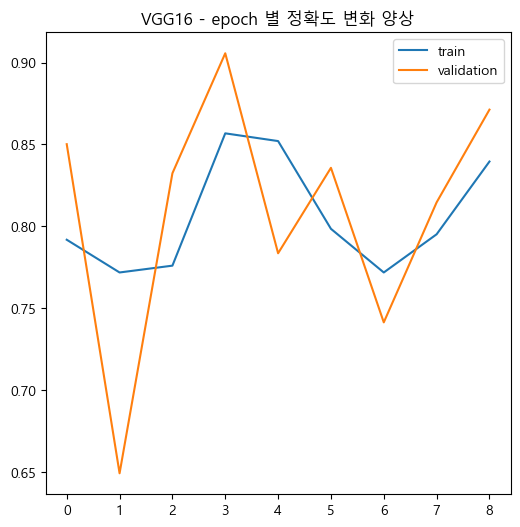

In [84]:
import matplotlib.pyplot as plt

# eopch 별 정확도 변화를 시각화하는 함수
def show_history(history):
    # 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.title('VGG16 - epoch 별 정확도 변화 양상')
    plt.legend()

# epoch 별 정확도 변화 시각화
show_history(history)

#### 1st Cycle - VGG16 모델 훈련 결과
- 마지막 epoch 이후 우수한 성능의 모델이 만들어짐
- 중간중간 loss가 튀는 현상이 발생했지만,  
  이는 최적의 가중치를 찾아가기 위한 과정으로 추정

### 🚩 VGG16 - 2nd Cycle
- load_weights로 성능이 가장 우수했던 때의 가중치를 불러온 다음 learning rate를 낮춰서 학습

In [85]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# VGG16 모델 생성 (+ 모델 구조 출력)
model = create_model(model_name='vgg16', verbose=True)

# 가중치 파일 불러오기
model.load_weights('./callback_files/vgg16/cycle1/weights.004-0.2944-0.8568.weights.h5')

# 모델 컴파일링
# 학습률 조정
model.compile(optimizer=Adam(1e-5), loss=CategoricalCrossentropy, metrics=['acc'])

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100)                 │          51,3

 Total params: 14,766,392 (56.33 MB)

 Trainable params: 14,766,392 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# callback 선언
mcp_cb = ModelCheckpoint(
    filepath="./callback_files/vgg16/cycle2/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

In [87]:
import gc

# Garbage Collecting
gc.collect()

15866

In [88]:
N_EPOCHS = 10

# 모델 학습
history = model.fit(train_flow,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS,
                    validation_data=validation_flow,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 110s 950ms/step - acc: 0.9071 - loss: 0.2862 - val_acc: 0.9101 - val_loss: 0.2770 - learning_rate: 1.0000e-05
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - acc: 0.9100 - loss: 0.2500 - val_acc: 0.9156 - val_loss: 0.2659 - learning_rate: 1.0000e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - acc: 0.9173 - loss: 0.2394 - val_acc: 0.9245 - val_loss: 0.2533 - learning_rate: 1.0000e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - acc: 0.9328 - loss: 0.2136 - val_acc: 0.9234 - val_loss: 0.2452 - learning_rate: 1.0000e-05
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - acc: 0.9229 - loss: 0.2388 - val_acc: 0.9245 - val_loss: 0.2399 - learning_rate: 1.0000e-05
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - acc: 0.9297 - loss: 0.2083 - val_acc: 0.9245 - val_loss: 0.2333 - learning_rate: 1.0000e-05
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - acc: 0.9288 - loss: 0.2074 - val_acc: 0.9290 - val_loss: 0.2

In [89]:
model.evaluate(test_flow)

36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - acc: 0.9560 - loss: 0.1726


[0.1720144897699356, 0.9511978626251221]

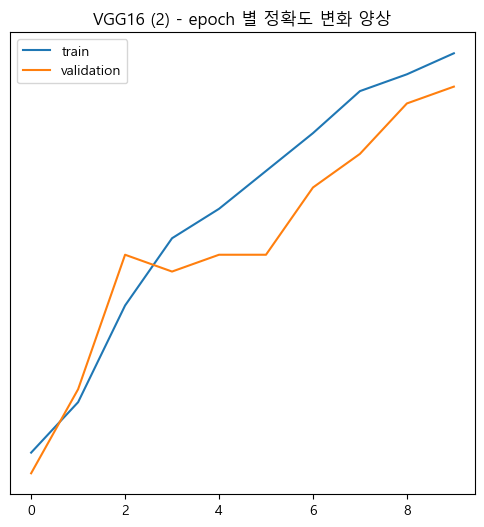

In [90]:
import matplotlib.pyplot as plt

# eopch 별 정확도 변화를 시각화하는 함수
def show_history(history):
    # 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.title('VGG16 (2) - epoch 별 정확도 변화 양상')
    plt.legend()

# epoch 별 정확도 변화 시각화
show_history(history)

#### 🤖 1st Cycle - VGG16 모델 성능 검증
- 시각화를 통해 모델이 실제 이미지를 얼마나 잘 예측하는지 확인

In [91]:
import matplotlib.pyplot as plt
# 이미지 출력 함수
def show_image(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')

In [92]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

# 모델 생성 후 최적의 가중치 로드, 이후 컴파일링
model = create_model(model_name='vgg16', verbose=True)
model.load_weights('./callback_files/vgg16/cycle2/weights.010-0.2117-0.9378.weights.h5')
model.compile(optimizer=Adam(1e-5), loss=CategoricalCrossentropy, metrics=['acc'])

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_13          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 100)                 │          51,3

 Total params: 14,766,392 (56.33 MB)

 Trainable params: 14,766,392 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

#### 이미지 시각화를 위한 데이터 준비

In [93]:
import albumentations as A
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

# train, validation, test DataFrame으로부터 file_paths(이미지)의 경로값과 원핫 인코딩 된 targets 가져오기
train_file_paths = train_df['file_paths'].values
train_targets = pd.get_dummies(train_df['targets']).values

validation_file_paths = validation_df['file_paths'].values
validation_targets = pd.get_dummies(validation_df['targets']).values

test_file_paths = test_df['file_paths'].values
test_targets = pd.get_dummies(test_df['targets']).values

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


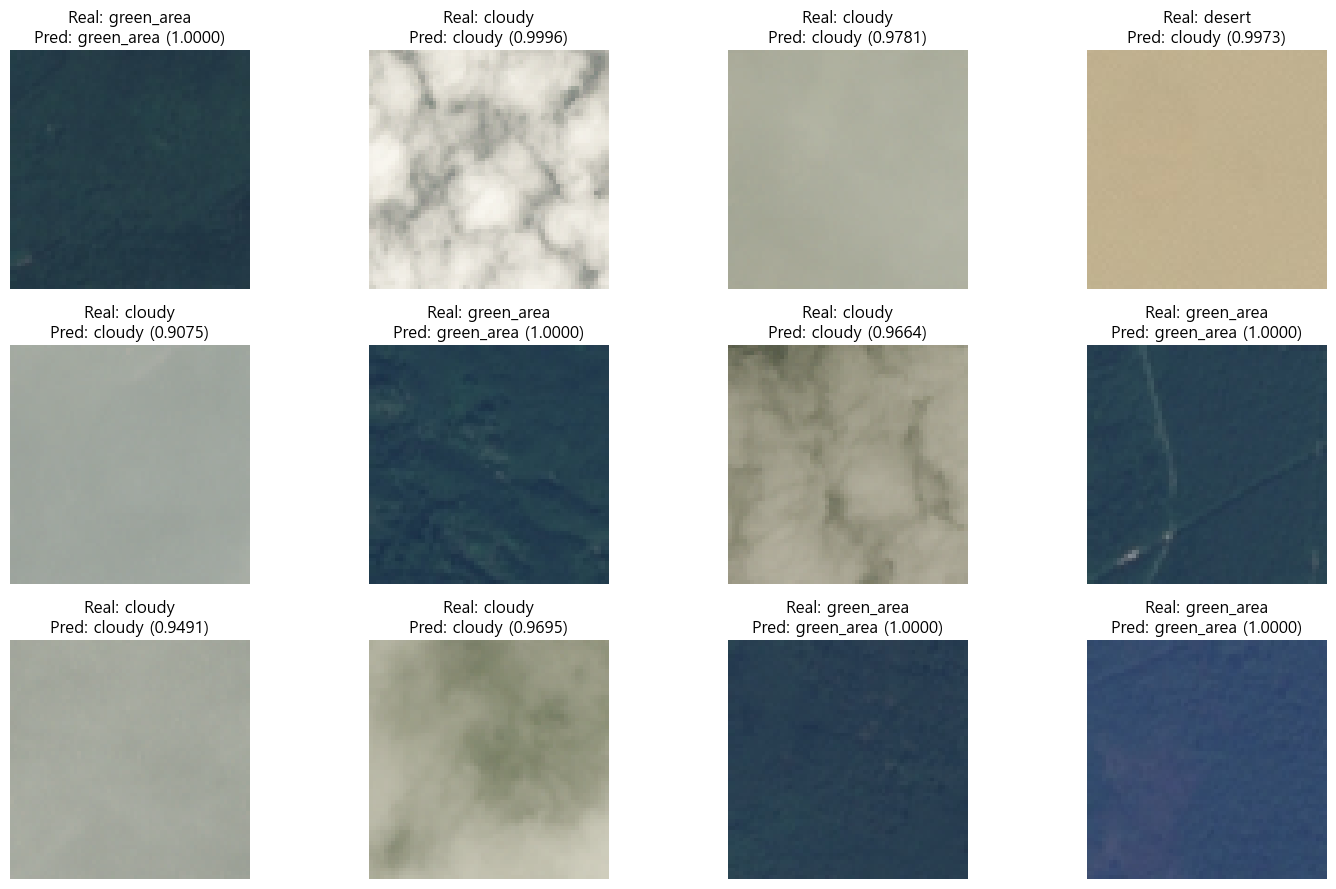

In [106]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

IMAGE_SIZE = 64
BATCH_SIZE = 20

# 데이터 클래스
class_names = ['cloudy', 'desert', 'green_area', 'water']

# 선택할 이미지의 시작 인덱스와 끝 인덱스 지정
start_index = 350
end_index = 362

# 행과 열의 개수 지정
num_rows = (end_index - start_index + 3) // 4  # +3 ensures rounding up
num_cols = 4

# 서브플롯 설정
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# 시작부터 끝 인덱스까지의 이미지들과 예측 클래스 시각화
for idx, i in enumerate(range(start_index, end_index)):
    # 위 인덱스 번호를 하나하나 순회하면서 이미지 파일 경로 가져오기
    selected_file_path = train_file_paths[i]

    # 이미지 로드 및 전처리
    image = cv2.cvtColor(cv2.imread(selected_file_path), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    processed_image = vgg16_preprocess_input(image.copy())

    # 모델로 이미지 예측
    predicted_probabilities = model.predict(np.expand_dims(processed_image, axis=0))

    # 예측 클래스 및 확률 출력
    predicted_class_index = np.argmax(predicted_probabilities)
    predicted_class_name = class_names[3 - predicted_class_index]
    predicted_probability = predicted_probabilities[0][predicted_class_index]

    # 실제 클래스 정보 가져오기
    real_class_index = np.where(train_targets[i])[0][0]  # True 값의 인덱스 가져오기
    real_class_name = class_names[real_class_index]

    # 서브플롯에 이미지와 텍스트 출력
    ax = axs[idx // num_cols, idx % num_cols]
    ax.imshow(image)
    ax.set_title(f"Real: {real_class_name}\nPred: {predicted_class_name} ({predicted_probability:.4f})")
    ax.axis('off')

# 남은 서브플롯을 비활성화
for j in range(idx + 1, num_rows * num_cols):
    axs[j // num_cols, j % num_cols].axis('off')

plt.tight_layout()
plt.show()

#### 1st Cycle - VGG16 모델 훈련 결과 (2)
- 위 12가지의 이미지들 중 11개에 대해 정확한 예측을 함
- 이전 사이클에서 가장 우수한 평가를 기록한 모델의 가중치를 불러와 학습한 결과,  
  해당 가중치로부터 더욱 우수한 성능을 가진 모델을 얻을 수 있었음

### 🚩 요약 및 느낀점
- optimizer(Adam)의 learning rate를 따로 설정하지 않고, default 값인 1e-3을 그대로 사용해서 학습한 결과  
  학습 중간에 정확도와 loss가 튀는 현상이 발견되었다.
- 이는 Adam optimizer가 Momentum과 RMSProp를 결합한 방식이고,  
  이번 프로젝트에서는 Momentum의 가중치 업데이트 방식(관성) 때문에 위와 같은 현상이 나타났다고 할 수 있다.
- 따라서 가장 낮은 val_loss를 보인 epoch의 가중치를 적용한 뒤, 학습률을 낮춰줌으로써  
  더 좁은 보폭으로 학습하게 하여 위 현상을 해결함과 동시에 모델의 예측 성능도 향상시켰다.

- 위 과정을 거치면서 모델에 적합한 학습률을 찾아 적용시키는 것이 모델 성능 향상에 중요하게 작용한다는 것을 알게되었다.